# <center>Trabalho final - Introdução à Ciência dos Dados</center>
<center>Universidade Federal de Minas Gerais</center>
<center>Integrantes do grupo: Breno Matos, Ramon Gonze, Rennan Cordeiro</center>

---
# <center> Crimes em Chicago: 2015 - 2018</center>
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import geopy.distance
import datetime
import seaborn as sns
from matplotlib import rcParams
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense 
from nltk.corpus import stopwords
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

sns.set()
%matplotlib inline

rcParams['figure.figsize'] = 11.7,8.27
FILE_PATH = "Crimes_2015_to_2018.csv"

np.random.seed(42)

Using TensorFlow backend.


## Funções úteis

In [2]:
def plot_dist(data,label,title,threshold=None):
    data[label].unique()
    df = data[[label,'ID']]
    df = df.groupby([label]).count()
    if(threshold):
        df = df[df["ID"]>threshold]
    
    df = df.sort_values('ID')
    plt.figure(figsize=(12,12))
    plt.barh(df.index,df["ID"])
    plt.title(title)
    plt.show()
    
def plot_binary(yes,no,label):
    objects = ('Sim', 'Não')
    y_pos = np.arange(len(objects))
    size = [ff,tt]
    
    plt.figure(figsize=(5,5))
    plt.bar(y_pos, size, align='center')
    plt.xticks(y_pos, objects)
    plt.title(label)
    
def permute(data, column, fil, numPerm=10000):
    data_ = data.copy()
    diffs = np.array([])
    
    for _ in np.arange(numPerm):
        data_[column] = data_[column].sample(frac=1).reset_index(drop=True)
        
        filter = fil(data_[column])
        arr = data_[filter]['Arrest']
        nonArr = data_[~filter]['Arrest']

        diffs = np.append(diffs, (arr.mean() - nonArr.mean()))
        
    return diffs

def distance_from_center(point):
    center = (41.8776142,-87.6323187)
    point = point.replace("(", "").replace(")", "")
    point = (point.split(",")[0], point.split(",")[1])
    
    return int(geopy.distance.distance(center, point).km)

def train_model(skf,x_train,y_train):
    acc = 0
    fold = 0
    for t, val in skf.split(x_train, y_train):
        x_t,y_t = x_train[t],y_train[t]
        x_val,y_val = x_train[val],y_train[val]
        model = Sequential() 
        model.add(Dense(len(FEATURES), activation='sigmoid')) 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
        model.fit(x_train, y_train, epochs=3, batch_size=16, verbose=0) # MELHOR BATCH ATUAL= 16  acc 0.78
        scores = model.evaluate(x_test, y_test, verbose=0)
        fold+=1
        print("Acc Fold-{}: {}.".format(fold, scores[1]))
        acc+=scores[1]
    acc/=splits
    print("Acurácia de Treino: ",acc)

---
# <center> Caracterização </center>

In [3]:
data = pd.read_csv(FILE_PATH)
data.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,97460,11561837,JC110056,12/31/2018 11:59:00 PM,013XX W 72ND ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,...,-87.657709,"(41.763181359, -87.657709477)",17.0,22257.0,65.0,408.0,32.0,23.0,17.0,216.0
1,97461,11556487,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,...,-87.696064,"(41.689078832, -87.696064026)",33.0,4447.0,73.0,256.0,42.0,33.0,9.0,254.0
2,97462,11552699,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,...,-87.647391,"(41.740520866, -87.647390719)",18.0,21554.0,70.0,530.0,13.0,59.0,20.0,233.0
3,97463,11552724,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,0440,BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,OTHER,True,...,-87.657625,"(41.857068095, -87.657625201)",8.0,14920.0,33.0,365.0,26.0,43.0,15.0,150.0
4,97464,11552731,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,...,-87.647717,"(41.75191443, -87.647716532)",17.0,21554.0,70.0,487.0,31.0,59.0,20.0,229.0


## Distribuição dos tipos de crimes

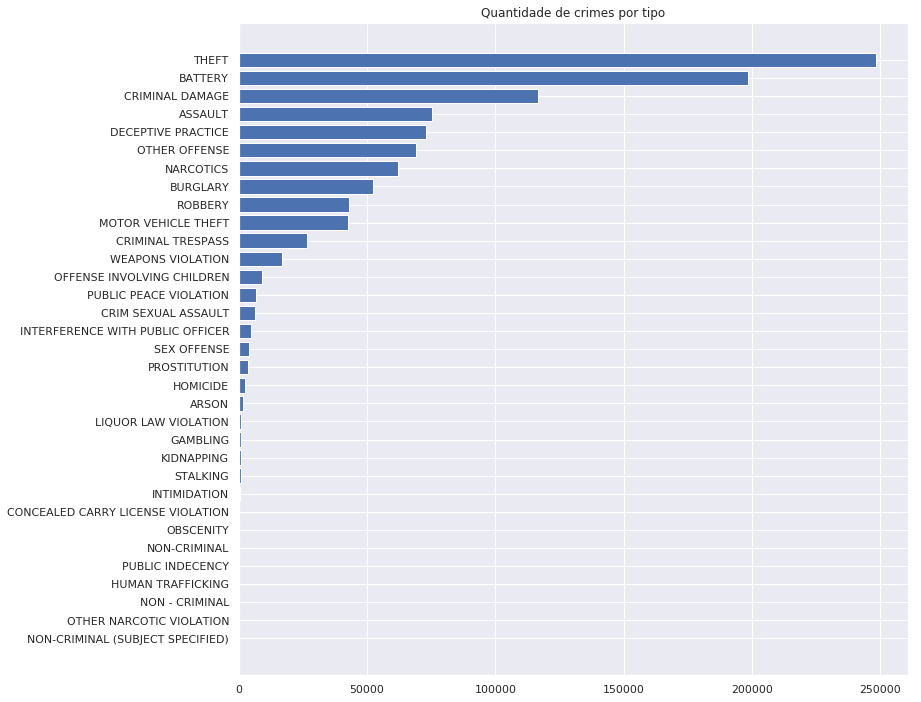

In [4]:
plot_dist(data,'Primary Type','Quantidade de crimes por tipo')

## Distribuição dos Locais

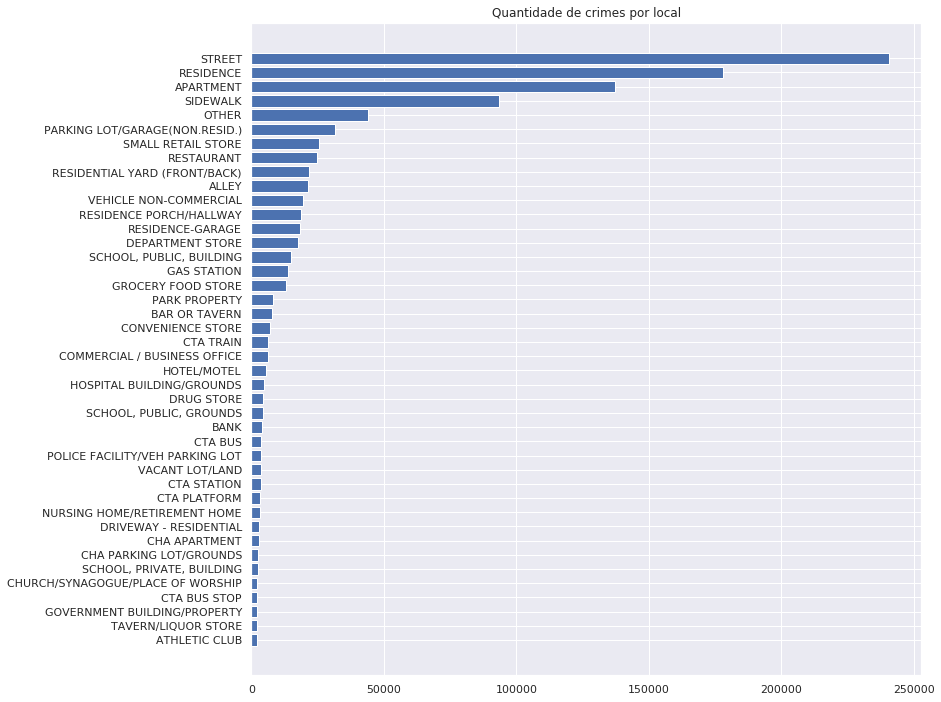

In [5]:
# Aqui descrevemos os tipos de locais possiveis. Filtramos por quantidade
plot_dist(data,'Location Description','Quantidade de crimes por local', threshold=2000)

## Distribuição de Prisões

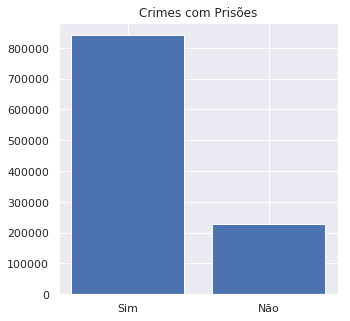

In [6]:
ff = len(data[data["Arrest"]==False])
tt = len(data[data["Arrest"]==True])
sz = ff+tt

plot_binary(tt,ff,"Crimes com Prisões")

## Distribuição de Crimes Domésticos

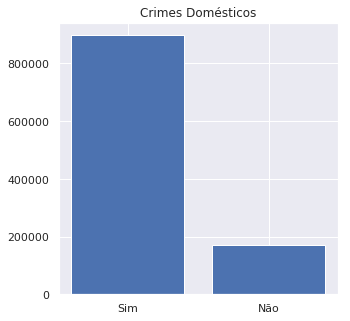

In [7]:
ff = len(data[data["Domestic"]==False])
tt = len(data[data["Domestic"]==True])
sz = ff+tt

plot_binary(tt,ff,"Crimes Domésticos")

Abaixo, tratamento das datas contidas no arquivo

In [8]:
data['Date'] =  pd.to_datetime(data['Date'])
data['Date'].dt.month.head()

0    12
1    12
2    12
3    12
4    12
Name: Date, dtype: int64

---
# <center> Testes de hipótese </center>

## Crimes em ambientes domésticos

In [9]:
domestic = data[data['Domestic'] == True]['Arrest']
nonDomestic = data[data['Domestic'] == False]['Arrest']
realDiff_ = domestic.mean() - nonDomestic.mean() # Mean difference of arrests in domestic and non domestic environments

In [10]:
diffs_ = permute(data[['Domestic', 'Arrest']], 'Domestic', lambda x: x == True)

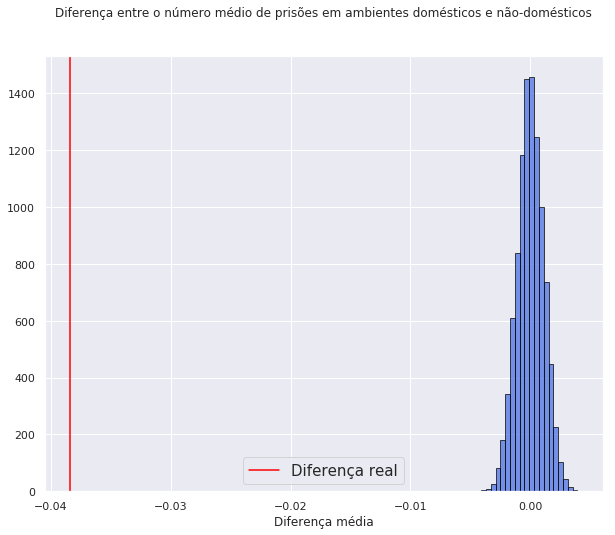

In [11]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,8))
plt.xlabel('Diferença média')
plt.hist(diffs_, bins=20, color='royalblue', edgecolor='black', alpha=0.7)
plt.title('Diferença entre o número médio de prisões em ambientes domésticos e não-domésticos', pad=40)
plt.axvline(realDiff_, color='red', label='Diferença real')
plt.legend(fontsize=15)

---
## Crimes ocorridos no centro da cidade e na periferia

In [37]:
Centerdf = data.copy()
Centerdf = Centerdf.dropna(subset=['Location'])

In [38]:
Centerdf["Distance"] = Centerdf["Location"].apply(distance_from_center)

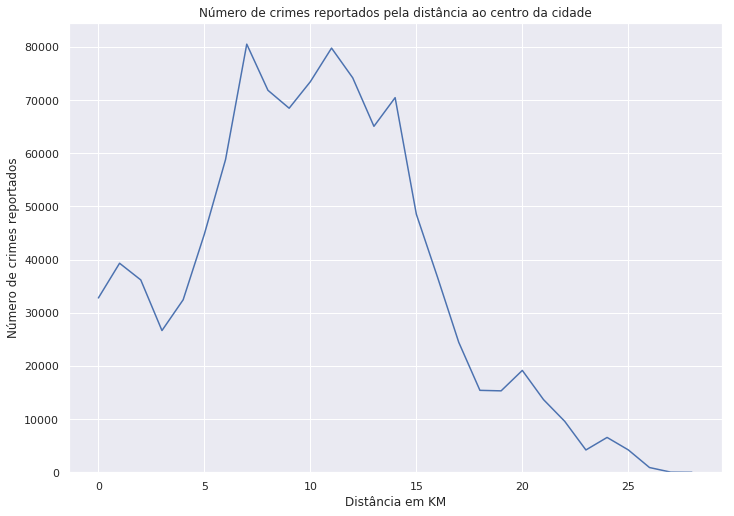

In [14]:
distances = Centerdf.groupby(["Distance"]).size()
plt.figure(figsize=(11.7,8.27))
plt.plot(distances)
plt.xlabel('Distância em KM')
plt.ylabel('Número de crimes reportados')
plt.title("Número de crimes reportados pela distância ao centro da cidade")
plt.ylim(bottom=0)
plt.show()

## Diferença entre região central e não central

In [39]:
block1 = Centerdf[Centerdf['Distance'] > 2]['Arrest']
block2 = Centerdf[Centerdf['Distance'] <= 2]['Arrest']
realDiff = block1.mean() - block2.mean()
Centerdf_ = Centerdf[['Distance','Arrest']].copy()
Centerdf_['Distance'] = (lambda x : x > 2)(Centerdf['Distance'])

In [59]:
newDF = pd.DataFrame()
newDF['Distance'] = Centerdf_['Distance'].copy()
newDF['Arrest'] = Centerdf_['Arrest'].copy()
newDFSample = newDF.sample(frac=0.2).reset_index(drop=True)
diffs = permute(newDFSample, 'Distance', lambda x: x == True, 10000)

[]

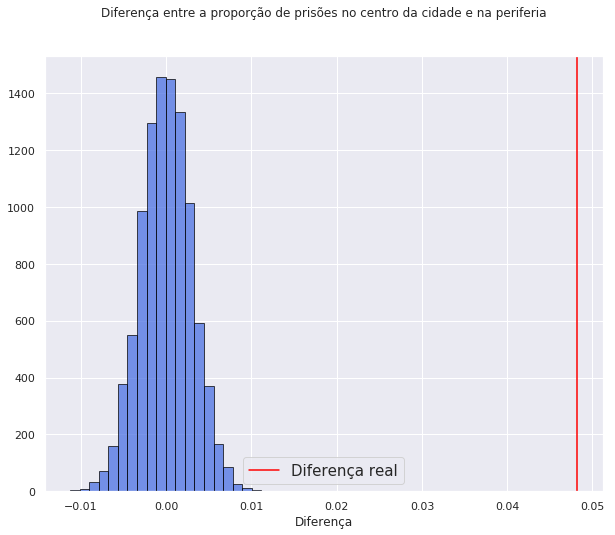

In [60]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,8))
plt.xlabel('Diferença')
plt.hist(diffs, bins=20, color='royalblue', edgecolor='black', alpha=0.7)
plt.title('Diferença entre a proporção de prisões no centro da cidade e na periferia', pad=40)
plt.axvline(realDiff, color='red', label='Diferença real')
plt.legend(fontsize=15)
plt.plot()

---
# <center> Regressão </center>

## Crimes por ano

In [18]:
yeardf = data.copy()
yeardf['Datetime'] = pd.to_datetime(data['Date'])

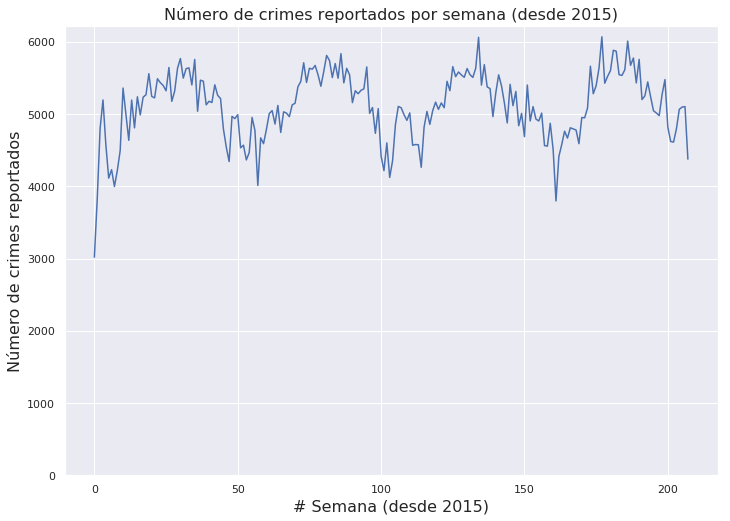

In [19]:
yeardf["Week"] = yeardf['Datetime'].dt.week
yeardf["Year"] = yeardf['Datetime'].dt.year
yeardf = yeardf[yeardf["Week"] != 53]
occurences = yeardf.groupby(["Year", "Week"]).size()
plt.figure(figsize=(11.7,8.27))
plt.plot(list(occurences))
plt.xlabel('# Semana (desde 2015)',fontsize=16)
plt.ylabel('Número de crimes reportados',fontsize=16)
plt.title("Número de crimes reportados por semana (desde 2015)",fontsize=16)
plt.ylim(bottom=0)
plt.show()

## Número de crimes semanais entre 2015 e 2018

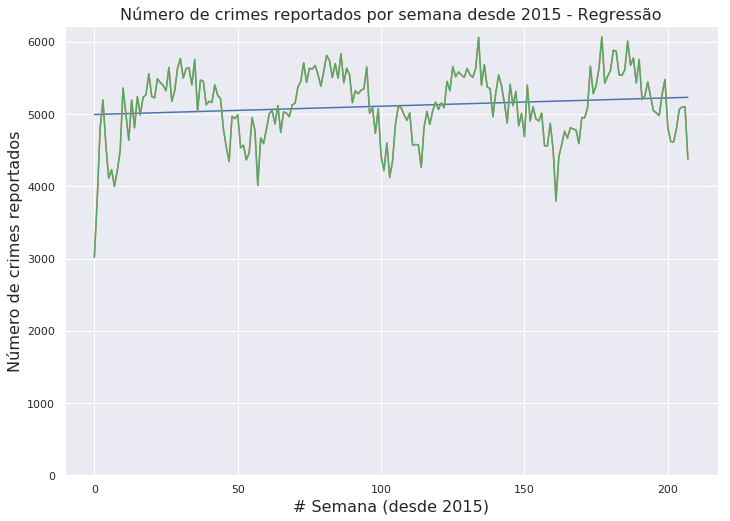

In [20]:
lis = list(occurences)
X = []
y = []
for a, b in enumerate(lis):
    X.append(a)
    y.append(b)
    
X = np.array(X).reshape(-1,1)
y = np.array(y).reshape(-1,1)

regressor = LinearRegression()
regressor.fit(X, y)
plt.figure(figsize=(11.7,8.27))
plt.plot(X,regressor.predict(X))
plt.plot(X,list(occurences))
plt.plot(list(occurences))
plt.xlabel('# Semana (desde 2015)',fontsize=16)
plt.ylabel('Número de crimes reportados',fontsize=16)
plt.title("Número de crimes reportados por semana desde 2015 - Regressão",fontsize=16)
plt.ylim(bottom=0)
plt.show()
yeardf = 1

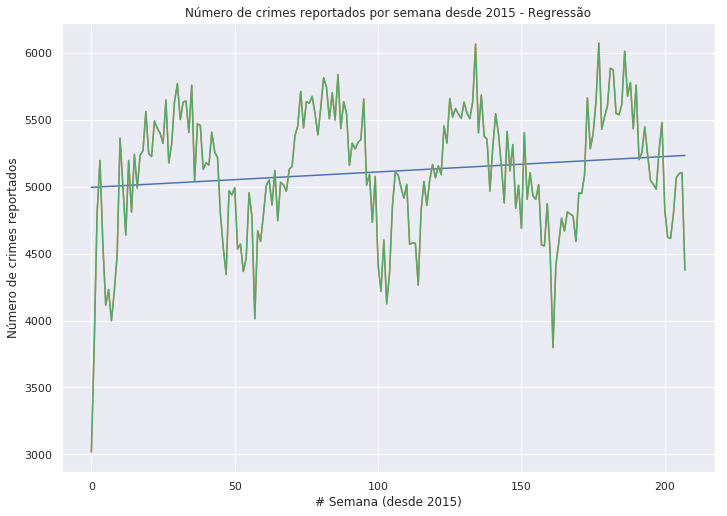

In [21]:
plt.figure(figsize=(11.7,8.27))
plt.plot(X,regressor.predict(X))
plt.plot(X,list(occurences))
plt.plot(list(occurences))
plt.xlabel('# Semana (desde 2015)')
plt.ylabel('Número de crimes reportados')
plt.title("Número de crimes reportados por semana desde 2015 - Regressão")
plt.show()

---
# <center> Classificação </center>

Abaixo utilizaremos dois Multilayer Perceptrons para relizar duas tarefas de classificação:
1. Classificar se um crime resultou em prisão
2. Se um crime foi do tipo 'domestic'

---
## Classificação 1

In [22]:
# Inicialmente utilizaremos as seguintes features:
FEATURES = ["Longitude","Latitude","Historical Wards 2003-2015","Zip Codes","Community Areas","Census Tracts","Wards","Boundaries - ZIP Codes","Police Districts","Police Beats","Arrest"]
TARGET = "Arrest"

features = data[FEATURES]
# results = data[TARGET]
# features = data[FEATURES]

# Alterando a coluna Arrest para valores categóricos
features = features.dropna()
FEATURES.remove("Arrest")
result = features[TARGET].apply(lambda x: 1 if x==True else 0)
features = features[FEATURES]

# Normalizando os Dados
features -= features.mean()
features /= features.std()
result.head()

0    0
1    0
2    0
3    1
4    0
Name: Arrest, dtype: int64

In [23]:
# Separação Treino-Teste
x_train,x_test,y_train,y_test = train_test_split(features,result,test_size=0.2)
x_test = x_test.values
x_train = x_train.values
y_test = y_test.values
y_train = y_train.values

### Treino e Validação

In [24]:
splits = 5
skf = StratifiedKFold(n_splits=splits,random_state=23)
acc = 0
fold = 0
for t, val in skf.split(x_train, y_train):
    x_t,y_t = x_train[t],y_train[t]
    x_val,y_val = x_train[val],y_train[val]
    model = Sequential() 
    model.add(Dense(len(FEATURES), activation='sigmoid')) 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=3, batch_size=16, verbose=0) # MELHOR BATCH ATUAL= 16  acc 0.78
    scores = model.evaluate(x_test, y_test, verbose=0)
    fold+=1
    print("Acc Fold-{}: {}.".format(fold, scores[1]))
    acc+=scores[1]
    
acc/=splits
print("Acurácia de Treino: ",acc)

Acc Fold-1: 0.7866709244455111.
Acc Fold-2: 0.7866709244455111.
Acc Fold-3: 0.7866709244455111.
Acc Fold-4: 0.7866709244455111.
Acc Fold-5: 0.7866709244455111.
Acurácia de Treino:  0.7866709244455111


### Teste

In [25]:
model = Sequential() 
model.add(Dense(len(FEATURES), activation='sigmoid')) 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

model.fit(x_train,y_train, epochs=3, batch_size=16, verbose=0)

print("Acc de Teste: {}".format(model.evaluate(x_test, y_test, verbose=0)[1]))

Acc de Teste: 0.7866709244455111


### Acurácia de Teste

In [26]:
print("Acc de Teste: {}".format(model.evaluate(x_test, y_test, verbose=0)[1]))

Acc de Teste: 0.7866709244455111


### Precision, Recall e F1

In [27]:
y_pred = model.predict(x_test,  batch_size=16, verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88    165053
           1       0.00      0.00      0.00     44759

   micro avg       0.79      0.79      0.79    209812
   macro avg       0.39      0.50      0.44    209812
weighted avg       0.62      0.79      0.69    209812



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
## Classificação 2
Agora queremos prever se um crime é do tipo doméstico ou não

In [28]:
FEATURES = ["Longitude","Latitude","Historical Wards 2003-2015","Zip Codes","Community Areas","Census Tracts","Wards","Boundaries - ZIP Codes","Police Districts","Police Beats","Domestic"]
TARGET = "Domestic"

features = data[FEATURES]

# Alterando a coluna Arrest para valores categóricos
features = features.dropna()
FEATURES.remove("Domestic")
result = features[TARGET].apply(lambda x: 1 if x==True else 0)
features = features[FEATURES]

# Normalizando os Dados
features -= features.mean()
features /= features.std()
result.head()

# Separação Treino-Teste
x_train,x_test,y_train,y_test = train_test_split(features,result,test_size=0.2)
x_test = x_test.values
x_train = x_train.values
y_test = y_test.values
y_train = y_train.values

### Treino e validação

In [29]:
splits = 5
skf = StratifiedKFold(n_splits=splits,random_state=23)

train_model(skf,x_train,y_train)

Acc Fold-1: 0.8393085238190531.
Acc Fold-2: 0.8393085238190531.
Acc Fold-3: 0.8393085238190531.
Acc Fold-4: 0.8393085238190531.
Acc Fold-5: 0.8393085238190531.
Acurácia de Treino:  0.8393085238190532


### Teste

In [30]:
model = Sequential() 
model.add(Dense(len(FEATURES), activation='sigmoid')) 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

model.fit(x_train,y_train, epochs=3, batch_size=16, verbose=0)

### Acurácia de teste

In [31]:
print("Acc de Teste: {}".format(model.evaluate(x_test, y_test, verbose=0)[1]))

Acc de Teste: 0.8393085238190531


### Precision, Recall e F1

In [32]:
y_pred = model.predict(x_test,  batch_size=16, verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91    176097
           1       0.00      0.00      0.00     33715

   micro avg       0.84      0.84      0.84    209812
   macro avg       0.42      0.50      0.46    209812
weighted avg       0.70      0.84      0.77    209812



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
